In [ ]:
import numba
import itertools
import numpy as np
import random as rd 
import matplotlib.pyplot as plt
import time
from numba import jit, config, threading_layer, set_num_threads
from numpy.random import random as npr
from numpy.random import default_rng
from scipy.ndimage import convolve, generate_binary_structure
import seaborn as sns
import pandas as pd
sns.set()
plt.rcParams["figure.figsize"] = (16,9)


L = 5  # L = tamanho da rede
L2 = L**2
S = np.array(rd.choices([-1], k=L2), dtype=np.float32).reshape(L,L)
lattice_n = S
N = L

teq = 1000

#funcs


In [ ]:
def E_dimensionless(config,L):
    total_energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%L, j] + config[i, (j+1)%L] + config[(i-1)%L, j] + config[i, (j-1)%L]
            total_energy += -nb * S
    return (total_energy/4)


In [ ]:
def get_energy(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()


@jit(nopython=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1-teq)
    net_energy = np.zeros(times-1-teq)
    for t in range(0,times-1):
      for i in range(L2):
          # 2. pick random point on array and flip spin
          x = np.random.randint(0,N)
          y = np.random.randint(0,N)
          spin_i = spin_arr[x,y] #initial spin
          spin_f = spin_i*-1 #proposed spin flip

          # compute change in energy
          E_i = 0
          E_f = 0
          if x>0:
              E_i += -spin_i*spin_arr[x-1,y]
              E_f += -spin_f*spin_arr[x-1,y]
          if x<N-1:
              E_i += -spin_i*spin_arr[x+1,y]
              E_f += -spin_f*spin_arr[x+1,y]
          if y>0:
              E_i += -spin_i*spin_arr[x,y-1]
              E_f += -spin_f*spin_arr[x,y-1]
          if y<N-1:
              E_i += -spin_i*spin_arr[x,y+1]
              E_f += -spin_f*spin_arr[x,y+1]

          # 3 / 4. change state with designated probabilities
          dE = E_f-E_i
          if (dE>0)*(np.random.random() < np.exp(-dE/BJ)):
              spin_arr[x,y]=spin_f
              energy += dE
          elif dE<=0:
              spin_arr[x,y]=spin_f
              energy += dE


      if t > teq:

        net_spins[t-teq] = spin_arr.sum()
        net_energy[t-teq] = energy
            
    return net_spins, net_energy    

#L4


In [ ]:
Temp = np.linspace(0.1,5, 25)
Lspace = [4]
for i,L in enumerate(Lspace):
  L2 = L*L
  mag_mean = []
  e_mean = []
  f_mean = []
  cv_mean = []
  xx_mean = []

  for k in range(len(Temp)):
    T = Temp[k]     
    E = 0
    peso = 0    
    Z    = 0   
    mag  = 0  
    mag2 = 0    
    e2   = 0   
    e    = 0
    #reshape 
    for state in itertools.product([1,-1],repeat=L2):
      s = np.array(state).reshape((L,L))

      E = E_dimensionless(s, L)*2
      peso = np.exp(-E/T)                            
      Z = Z + peso                          
      e = e + (E/L2)*peso
      e2 = e2 +(E/L2)**2*peso
      #print(peso)

      mag = mag + abs(np.sum(s))/L2*peso
      mag2 = mag2 + ((np.sum(s))/L2)**2*peso



    xx_mean.append((L2/T)*(mag2/Z - (mag/Z)**2))
    cv_mean.append(L2/(T**2)*(e2/Z - (e/Z)**2))
    mag_mean.append(mag/Z)
    e_mean.append(e/Z)
    f_mean.append(-T/L2*np.log(Z))

KeyboardInterrupt: ignored

In [ ]:
temps = np.linspace(0.5, 5 , 25)
teq = 200
time = 10000
historias = 1
L = 5
L2 = L*L



In [ ]:
tmag = []
TE = []
Tcv = []
Tx = []


for temp in temps:
  maglist = []
  Elist = []
  cvlist = []
  xlist = []

  for h in range(historias):
    Sr = np.array(rd.choices([1, -1], k=L2), dtype=np.float32).reshape(L,L)  
    mag, E = metropolis(Sr, time, temp, get_energy(Sr))
    

    Eeq = (E/L2).mean()
    Eeq2 = ((E/L2)**2).mean()

    mageq = (abs(mag)/L2).mean()
    mageq2 = ((mag/L2)**2).mean() 
    
    xlist.append(L2/temp*(mageq2 - (mageq**2)))
    cvlist.append(L2/(temp**2)*(Eeq2 - (Eeq**2)))
    #  cv_mean.append(L2/(T**2)*(e2/Z - (e/Z)**2))

    Elist.append(Eeq)
    maglist.append(mageq)


  Tx.append(np.mean(xlist)) 
  Tcv.append(np.mean(cvlist))   
  TE.append(np.mean(Elist))  
  tmag.append(np.mean(maglist)) 

ValueError: ignored

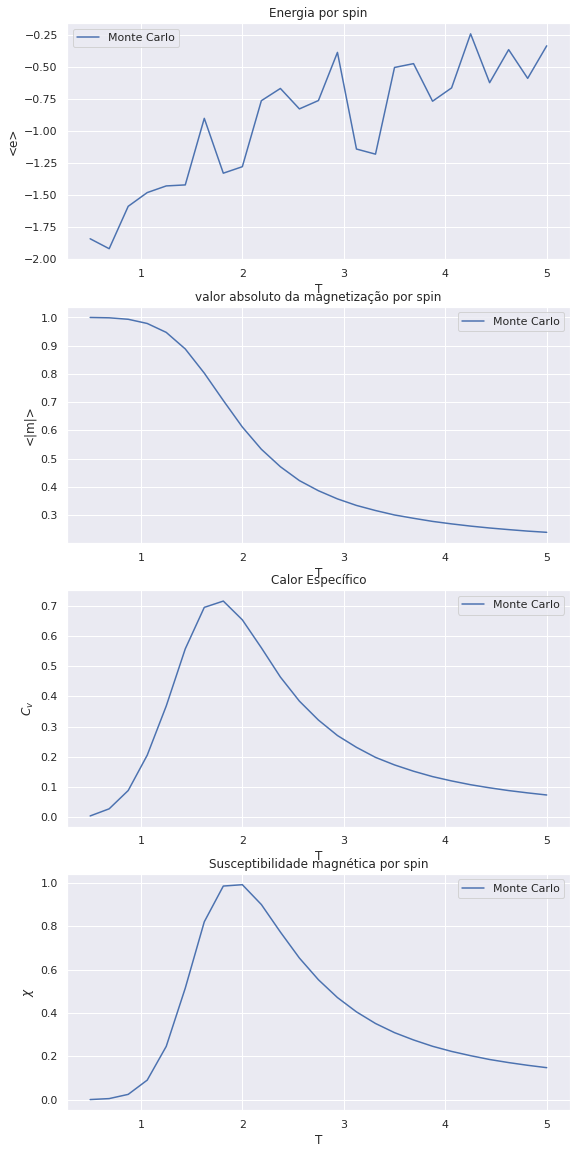

In [ ]:
#plt.plot(temps, Tcv)



fig, ax = plt.subplots(4,1, figsize=(9,20))


ax[0].plot(temps, TE, label='Monte Carlo')
#ax[0].plot(Temp, e_mean, label='Exata')
ax[0].set(xlabel='T', ylabel='<e>', title='Energia por spin' )
ax[0].legend()

ax[1].plot(temps, tmag, label='Monte Carlo')
#ax[1].plot(Temp, mag_mean, label='Exata')
ax[1].set(xlabel='T', ylabel='<|m|>', title='valor absoluto da magnetização por spin' )
ax[1].legend()

ax[2].plot(temps, Tcv, label='Monte Carlo')
#ax[2].plot(Temp, cv_mean, label='Exata')
ax[2].set(xlabel='T', ylabel='$C_v$', title='Calor Específico' )
ax[2].legend()

ax[3].plot(temps, Tx, label='Monte Carlo')
#ax[3].plot(Temp, xx_mean, label='Exata')
ax[3].set(xlabel='T', ylabel='$\chi$', title='Susceptibilidade magnética por spin' )
ax[3].legend()



#L 5 


In [ ]:
exata5 = pd.read_csv('/content/sumZL5.dat', sep = ' ',  usecols=[0,1,2,3,4], names=['T', 'm', 'e', 'x', 'cv'], header=None)

In [ ]:
df = exata5.drop(0)
df= df.astype(np.float64)

In [ ]:
temps = np.linspace(0.5, 5 , 25)
tc = 2.27
teq = 10000
time = 1000000
historias = 1
L = 5
L2 = L*L



In [ ]:
tmag = []
TE = []
Tcv = []
Tx = []


for temp in temps:
  maglist = []
  Elist = []
  cvlist = []
  xlist = []

  for h in range(historias):
    Sr = np.array(rd.choices([-1,1], k=L2), dtype=np.float32).reshape(L,L)  
   #if temp < tc:
   #  Sr = np.array(rd.choices([ 1], k=L2), dtype=np.float32).reshape(L,L)  
    mag, E = metropolis(Sr, time, temp, get_energy(Sr))
    

    Eeq = np.mean((E/L2))
    Eeq2 = np.mean((E/L2)**2)

    mageq =  np.mean((abs(mag)/L2))
    mageq2 = np.mean(((mag/L2)**2))
    
    xlist.append(L2/temp*(mageq2 - (mageq**2)))
    cvlist.append(L2/(temp**2)*(Eeq2 - (Eeq**2)))


    Elist.append(Eeq)
    maglist.append(mageq)


  Tx.append(np.mean(xlist)) 
  Tcv.append(np.mean(cvlist))   
  TE.append(np.mean(Elist))  
  tmag.append(np.mean(maglist)) 

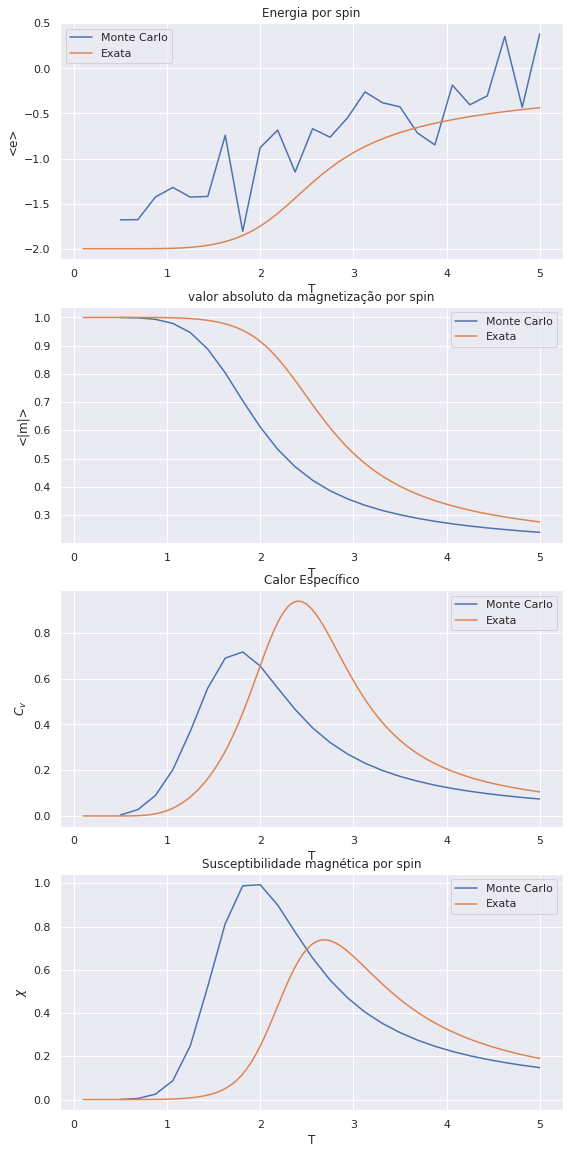

In [ ]:
#L = 5

fig, ax = plt.subplots(4,1, figsize=(9,20))


ax[0].plot(temps, TE, label='Monte Carlo')
ax[0].plot(df['T'],df['e'] , label='Exata')
ax[0].set(xlabel='T', ylabel='<e>', title='Energia por spin' )
ax[0].legend()

ax[1].plot(temps, tmag, label='Monte Carlo')
ax[1].plot(df['T'],df['m'],  label='Exata')
ax[1].set(xlabel='T', ylabel='<|m|>', title='valor absoluto da magnetização por spin' )
ax[1].legend()

ax[2].plot(temps, Tcv, label='Monte Carlo')
ax[2].plot(df['T'],df['cv'],  label='Exata')
ax[2].set(xlabel='T', ylabel='$C_v$', title='Calor Específico' )
ax[2].legend()

ax[3].plot(temps, Tx, label='Monte Carlo')
ax[3].plot(df['T'],df['x'], label='Exata')
ax[3].set(xlabel='T', ylabel='$\chi$', title='Susceptibilidade magnética por spin' )
ax[3].legend()


#EXTRAAA

In [ ]:
lattice_n = np.array(rd.choices([-1], k=L2), dtype=np.float32).reshape(L,L)
S1 = np.array(rd.choices([1], k=L2), dtype=np.float32).reshape(L,L)
Sr = np.array(rd.choices([1, -1], k=L2), dtype=np.float32).reshape(L,L)



spins3, energies3 = metropolis(lattice_n, 10000, 3, get_energy(lattice_n))
spins1, energies1 = metropolis(lattice_n, 10000, 1.5, get_energy(lattice_n))
spins2, energies2 = metropolis(lattice_n, 10000, 2, get_energy(lattice_n))



spins31, energies31 = metropolis(S1, 10000, 3, get_energy(S1))
spins11, energies11 = metropolis(S1, 10000, 1.5, get_energy(S1))
spins21, energies21 = metropolis(S1, 10000, 2, get_energy(S1))

sr3, er3 = metropolis(Sr, 10000, 3, get_energy(Sr))
sr1, er1 = metropolis(Sr, 10000, 1.5, get_energy(Sr))
sr2, er2 = metropolis(Sr, 10000, 2, get_energy(Sr))


No handles with labels found to put in legend.


<bound method Figure.tight_layout of <Figure size 864x288 with 1 Axes>>

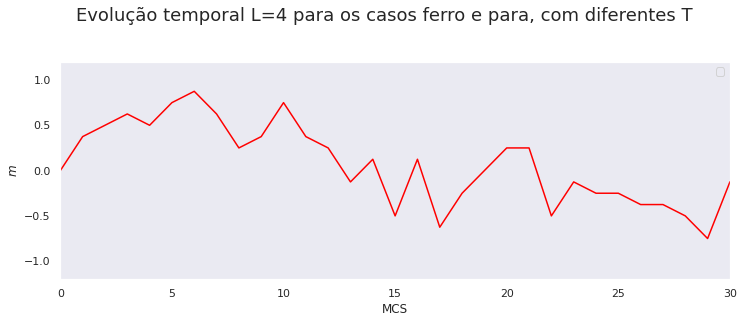

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

#ax.plot(spins11/L2, label='T= 1.5', color= 'blue')
#ax.plot(spins1/L2, color= 'blue')
#ax.plot(sr1/L2, color= 'blue')
#
#ax.plot(spins21/L2, color= 'yellow')
#ax.plot(spins2/L2, label = 'T= 2' , color= 'yellow')
#ax.plot(sr2/L2, color= 'yellow')

#ax.plot(spins31/L2, label = 'T= 3', color= 'red')
#ax.plot(spins3/L2, color= 'red')
ax.plot(sr3/L2, color= 'red')

ax.legend()
ax.set_xlabel('MCS')
ax.set_ylabel(r'$m$')
ax.grid()
ax.set(ylim= [-1.2,1.2], xlim=[0,30])



#ax[1].plot(0.5*energies11/L2, label='T= 1.5', color= 'blue')
#ax[1].plot(0.5*energies1/L2, color= 'blue')
#ax[1].plot(0.5*energies21/L2, color= 'yellow')
#ax[1].plot(0.5*energies2/L2, label = 'T= 2' , color= 'yellow')
#ax[1].plot(0.5*energies31/L2, label = 'T= 3', color= 'red')
#ax[1].plot(0.5*energies3/L2, color= 'red')
#
#
#
#
#ax[1].legend()
#ax[1].plot(energies1/L2)
#ax[1].set_xlabel('MCS')
#ax[1].set_ylabel(r'e')
#ax[1].set(ylim= [-2,0], xlim = [0, 200])
#ax[1].grid()

fig.suptitle(f'Evolução temporal L={L} para os casos ferro e para, com diferentes T', y=1.07, size=18)
fig.tight_layout





[(-2.0, 0.2), (0.0, 500.0)]

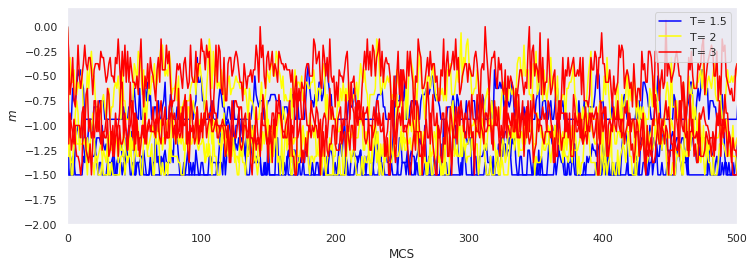

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

ax.plot(0.5*energies11/L2, label='T= 1.5', color= 'blue')
ax.plot(0.5*energies1/L2, color= 'blue')
ax.plot(0.5*er1/L2, color= 'blue')

ax.plot(0.5*energies21/L2, color= 'yellow')
ax.plot(0.5*energies2/L2, label = 'T= 2' , color= 'yellow')
ax.plot(0.5*er2/L2, color= 'yellow')

ax.plot(0.5*energies31/L2, label = 'T= 3', color= 'red')
ax.plot(0.5*energies3/L2, color= 'red')
ax.plot(0.5*er3/L2, color= 'red')

ax.legend()
ax.set_xlabel('MCS')
ax.set_ylabel(r'$m$')
ax.grid()
ax.set(ylim= [-2,0.2], xlim = [0, 500])

In [ ]:
def get_energy(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()


@jit(nopython=True)
def dt_metropolis(spin_arr, times, BJ, energy, dt):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    net_BJ = np.zeros(times-1)


    for t in range(0,times-1):


      for i in range(L2):
          
          # 2. pick random point on array and flip spin
          x = np.random.randint(0,N)
          y = np.random.randint(0,N)
          spin_i = spin_arr[x,y] #initial spin
          spin_f = spin_i*-1 #proposed spin flip

          # compute change in energy
          E_i = 0
          E_f = 0
          if x>0:
              E_i += -spin_i*spin_arr[x-1,y]
              E_f += -spin_f*spin_arr[x-1,y]
          if x<N-1:
              E_i += -spin_i*spin_arr[x+1,y]
              E_f += -spin_f*spin_arr[x+1,y]
          if y>0:
              E_i += -spin_i*spin_arr[x,y-1]
              E_f += -spin_f*spin_arr[x,y-1]
          if y<N-1:
              E_i += -spin_i*spin_arr[x,y+1]
              E_f += -spin_f*spin_arr[x,y+1]

          # 3 / 4. change state with designated probabilities
          dE = E_f-E_i
          if (dE>0)*(np.random.random() < np.exp(-dE/BJ)):
              spin_arr[x,y]=spin_f
              energy += dE
          elif dE<=0:
              spin_arr[x,y]=spin_f
              energy += dE

      net_spins[t] = spin_arr.sum()
      net_energy[t] = energy
      
      BJ = BJ + dt*t 
      net_BJ[t] = BJ

    return net_spins, net_energy, net_BJ

In [ ]:
lattice_n = np.array(rd.choices([-1], k=L2), dtype=np.float32).reshape(L,L)
S1 = np.array(rd.choices([1], k=L2), dtype=np.float32).reshape(L,L)
Sr = np.array(rd.choices([1, -1], k=L2), dtype=np.float32).reshape(L,L)


spins1, energies1, T1 = dt_metropolis(lattice_n, 10000, 1, get_energy(lattice_n), 0.001)
spins3, energies3, T3 = dt_metropolis(lattice_n, 10000, 1, get_energy(lattice_n), 0.0001)


spins11, energies11, T12 = dt_metropolis(S1, 10000, 1, get_energy(S1), 0.001)
spins31, energies31, T32 = dt_metropolis(S1, 10000, 1, get_energy(S1), 0.0001)




In [ ]:
spins31, energies31, T32 = dt_metropolis(S1, 10000, 1, get_energy(S1), 0.0001)

In [ ]:
energies31/2/L2

array([-1.5   , -1.5   , -1.5   , ..., -0.6875, -0.75  , -0.8125])

<bound method Figure.tight_layout of <Figure size 864x288 with 1 Axes>>

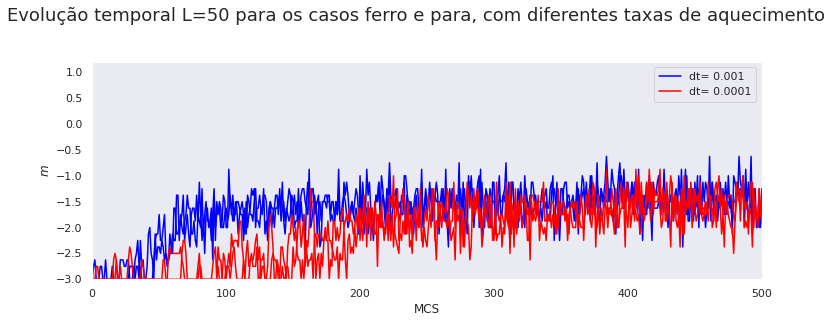

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

ax.plot(energies11/L2, label='dt= 0.001', color= 'blue')
ax.plot(energies1/L2, color= 'blue')


ax.plot(energies31/L2, label = 'dt= 0.0001', color= 'red')
ax.plot(energies3/L2, color= 'red')

ax.legend()
ax.set_xlabel('MCS')
ax.set_ylabel(r'$m$')
ax.grid()
ax.set(ylim= [-3,1.2], xlim = [0, 500])
fig.suptitle(r'Evolução temporal L=50 para os casos ferro e para, com diferentes taxas de aquecimento', y=1.07, size=18)
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 864x288 with 1 Axes>>

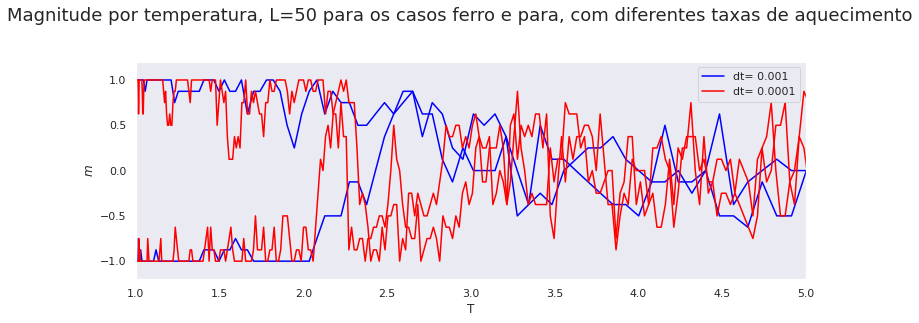

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

ax.plot(T12,spins11/L2, label='dt= 0.001', color= 'blue')
ax.plot(T1,spins1/L2 ,   color= 'blue')


ax.plot(T32,spins31/L2, label = 'dt= 0.0001', color= 'red')
ax.plot(T3,spins3/L2,  color= 'red')


ax.legend()
ax.set_xlabel('T')
ax.set_ylabel(r'$m$')
ax.grid()
ax.set(ylim= [-1.2,1.2], xlim = [1, 5])


fig.suptitle(r'Magnitude por temperatura, L=50 para os casos ferro e para, com diferentes taxas de aquecimento', y=1.07, size=18)
fig.tight_layout